In [58]:
import pandas as pd
import numpy as np

# Number of synthetic samples
n_samples = 1000

# Seed for reproducibility
np.random.seed(42)

# Generate synthetic data
data = {
    'Pregnancies': np.random.randint(0, 8, n_samples),
    'Age': np.random.randint(18, 45, n_samples),
    'BMI': np.round(np.random.uniform(18, 40, n_samples), 1),
    'BloodPressure': np.random.randint(60, 150, n_samples),
    'Glucose': np.random.randint(70, 200, n_samples),
    'Smoking': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),  # 20% smokers
    'Previous_Preterm_Births': np.random.randint(0, 3, n_samples),
    'Gestational_Diabetes': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),  # 10% with gestational diabetes
    'Genetic_Factors': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),  # 15% with genetic risk factors
    'Environmental_Factors': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),  # 30% with environmental risk factors
    
    # New attributes with values other than 0 and 1
    'PCOS': np.round(np.random.uniform(0, 10, n_samples), 1),  # Severity from 0 to 10
    'HIV': np.round(np.random.uniform(0, 100, n_samples), 1),  # Viral load from 0 to 100
    'Zika_infection': np.round(np.random.uniform(0, 50, n_samples), 1),  # Antibody level from 0 to 50
    'Thyroid': np.round(np.random.uniform(0, 5, n_samples), 1),  # Thyroid function score from 0 to 5
    'Autoimmune_disease': np.round(np.random.uniform(0, 10, n_samples), 1),  # Severity from 0 to 10
    'Kidney_disease': np.round(np.random.uniform(0, 100, n_samples), 1),  # Kidney function score from 0 to 100

    # Target variable - Gestational period in days (randomly generated between 200 to 300 days)
    'Gestational_Period_days': np.round(np.random.uniform(200, 290, n_samples), 1)
}

# Create DataFrame
synthetic_df = pd.DataFrame(data)

# Display the first few rows of the dataset
print(synthetic_df.head())

# Save to CSV
synthetic_df.to_csv('synthetic_pregnancy_dataset_with_additional_attributes.csv', index=False)


   Pregnancies  Age   BMI  BloodPressure  Glucose  Smoking  \
0            6   39  31.2            101      139        0   
1            3   34  37.9             65       85        0   
2            4   26  39.8             98      137        0   
3            6   18  34.4            111      168        0   
4            2   38  19.4             82      117        0   

   Previous_Preterm_Births  Gestational_Diabetes  Genetic_Factors  \
0                        2                     0                1   
1                        1                     0                0   
2                        0                     0                1   
3                        1                     0                1   
4                        1                     0                0   

   Environmental_Factors  PCOS   HIV  Zika_infection  Thyroid  \
0                      1   7.4   7.6            21.2      0.7   
1                      1   6.9  66.2            23.0      2.8   
2                

In [59]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Load Dataset
data = pd.read_csv('synthetic_pregnancy_dataset_with_additional_attributes.csv')  # Replace with the actual file path

# Define Features and Target Variable
features = ['Pregnancies', 'Age', 'BMI', 'BloodPressure', 'Glucose', 
            'Smoking', 'Previous_Preterm_Births', 'Gestational_Diabetes',
            'Genetic_Factors', 'Environmental_Factors',
            'PCOS', 'HIV', 'Zika_infection', 'Thyroid', 'Autoimmune_disease', 'Kidney_disease']
target = 'Gestational_Period_days'  # Adjust to your dataset's actual target variable

# Check if target column exists in the dataset
if target not in data.columns:
    raise ValueError(f"Target column '{target}' not found in dataset.")

# Handle missing values if any
data = data.dropna(subset=[target])  # Drop rows with missing target values
data[features] = data[features].fillna(data[features].mean())  # Fill missing feature values with the mean

# Separate features (X) and target (y)
X = data[features]
y = data[target]

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the Scaler for Later Use
joblib.dump(scaler, 'scaler.pkl')

# Initialize the Model (Random Forest Regressor)
model = RandomForestRegressor(random_state=42)

# Define Hyperparameter Grid for Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the Best Model from Grid Search
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Train the Best Model on the Full Training Data
best_model.fit(X_train_scaled, y_train)

# Make Predictions on the Test Set
y_pred = best_model.predict(X_test_scaled)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"R-squared (R2): {r2:.2f}")

# Save the Trained Model
joblib.dump(best_model, 'preterm_birth_rf_model.pkl')

# Display Feature Importance (for Random Forest)
feature_importances = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/rajeevkumar/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Mean Absolute Error (MAE): 22.42 days
Root Mean Squared Error (RMSE): 26.27 days
R-squared (R2): -0.00
Feature Importances:
 Zika_infection             0.103695
Autoimmune_disease         0.103540
Kidney_disease             0.098239
BMI                        0.097464
PCOS                       0.092150
HIV                        0.089434
BloodPressure              0.087169
Thyroid                    0.083732
Glucose                    0.079947
Age                        0.071483
Pregnancies                0.037682
Previous_Preterm_Births    0.019935
Environmental_Factors      0.010142
Smoking                    0.008911
Genetic_Factors            0.008696
Gestational_Diabetes       0.007781
dtype: float64


In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# Load the test dataset
test_data = pd.read_csv('Test_sample_new.csv')

# Define the features, including the newly added attributes
features = ['Pregnancies', 'Age', 'BMI', 'BloodPressure', 'Glucose', 
            'Smoking', 'Previous_Preterm_Births', 'Gestational_Diabetes',
            'Genetic_Factors', 'Environmental_Factors',
            'PCOS', 'HIV', 'Zika_infection', 'Thyroid', 'Autoimmune_disease', 'Kidney_disease']

# Load the scaler and apply it to the test data
scaler = joblib.load('scaler.pkl')
test_data_scaled = scaler.transform(test_data[features])

# Load the trained model
model = joblib.load('preterm_birth_rf_model.pkl')

# Make predictions
predictions = model.predict(test_data_scaled)

# Add predictions to the test dataset and display results
test_data['Predicted_Gestational_Period_Days'] = predictions

# Display the predictions
print(test_data[['Pregnancies', 'Age', 'BMI', 'BloodPressure', 'Glucose', 
            'Smoking', 'Previous_Preterm_Births', 'Gestational_Diabetes',
            'Genetic_Factors', 'Environmental_Factors',
            'PCOS', 'HIV', 'Zika_infection', 'Thyroid', 'Autoimmune_disease', 'Kidney_disease',
            'Predicted_Gestational_Period_Days']])

# Optionally, save the predictions to a new CSV file
test_data.to_csv('test_sample_with_predictions.csv', index=False)


    Pregnancies  Age   BMI  BloodPressure  Glucose  Smoking  \
0             6   39  31.2            101      139        0   
1             3   34  37.9             65       85        0   
2             4   26  39.8             98      137        0   
3             6   18  34.4            111      168        0   
4             2   38  19.4             82      117        0   
5             7   37  26.8            148      133        0   
6             4   30  36.4            109      159        0   
7             4   33  23.1            102      145        0   
8             6   30  36.3             78      170        1   
9             1   31  20.6            128      158        1   
10            2   20  19.0            110       87        1   
11            6   23  26.4             70       88        0   
12            2   35  18.8             71      124        1   
13            2   36  39.1            133      171        0   
14            7   22  36.2             67      187     

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=No

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=No

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=None

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=No

Model expects 16 features.


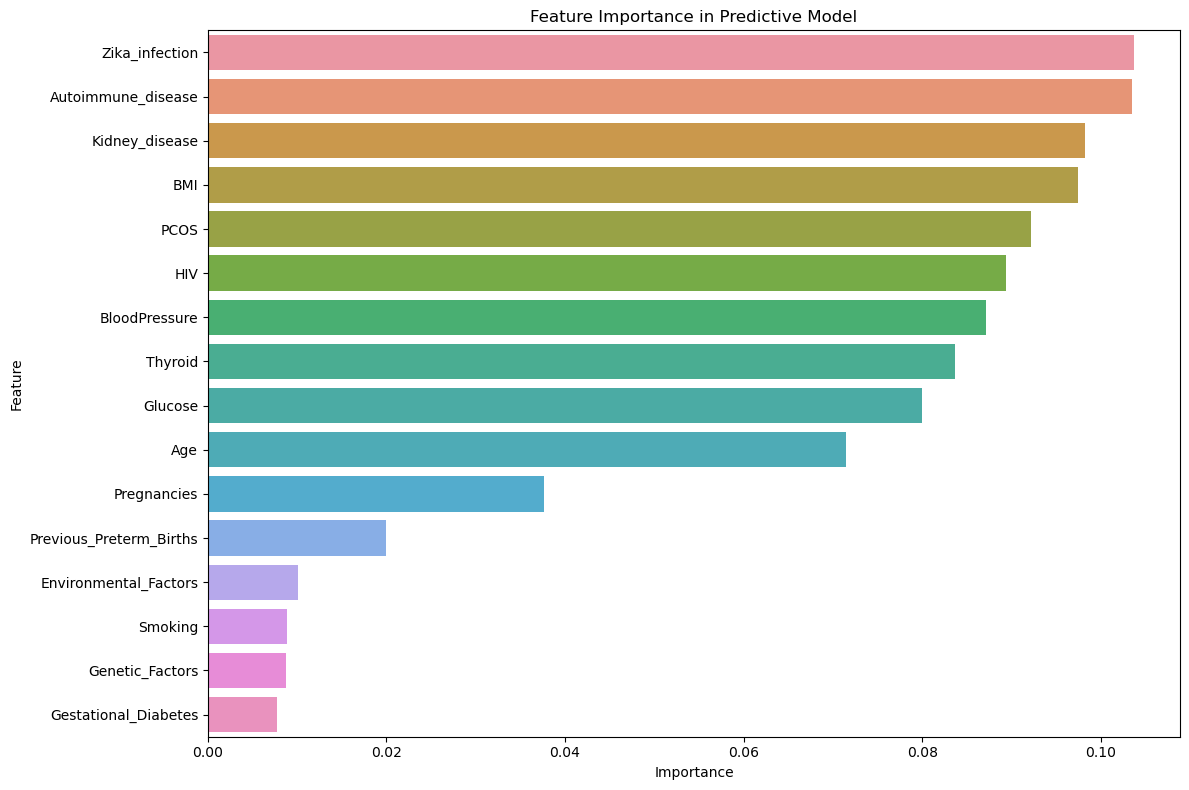

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the trained model
model = joblib.load('preterm_birth_rf_model.pkl')

# Check the number of features in the trained model
expected_num_features = model.n_features_in_
print(f"Model expects {expected_num_features} features.")

# Define the feature names, ensuring they match the order used in training
features = ['Pregnancies', 'Age', 'BMI', 'BloodPressure', 'Glucose', 
            'Smoking', 'Previous_Preterm_Births', 'Gestational_Diabetes',
            'Genetic_Factors', 'Environmental_Factors',
            'PCOS', 'HIV', 'Zika_infection', 'Thyroid', 'Autoimmune_disease', 'Kidney_disease']

# Confirm feature list matches the model's expected number of features
if len(features) != expected_num_features:
    raise ValueError(f"Feature list length ({len(features)}) does not match model's expected number of features ({expected_num_features}).")

# Extract feature importance
feature_importances = model.feature_importances_

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Predictive Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [8]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# Load your original training dataset
data = pd.read_csv('synthetic_pregnancy_dataset_with_additional_attributes.csv')  # Replace with the actual path to your training data

# Define only the 16 features you intend to use in the final model
features = ['Pregnancies', 'Age', 'BMI', 'BloodPressure', 'Glucose', 
            'Smoking', 'Previous_Preterm_Births', 'Gestational_Diabetes',
            'Genetic_Factors', 'Environmental_Factors',
            'PCOS', 'HIV', 'Zika_infection', 'Thyroid', 'Autoimmune_disease', 'Kidney_disease']

# Select these features from the training data
data = data[features]

# Initialize and fit the scaler
scaler = StandardScaler()
scaler.fit(data)

# Save the new scaler
joblib.dump(scaler, 'scaler_updated.pkl')
print("scaler_updated.pkl has been saved.")


scaler_updated.pkl has been saved.


In [19]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Load Dataset
data = pd.read_csv('synthetic_validation_data.csv')  # Replace with actual file path

# Check if target column exists
target = 'Gestational_Period_days'
if target not in data.columns:
    raise KeyError(f"Target column '{target}' not found in the dataset. Available columns are: {data.columns.tolist()}")

# Define Features and Target Variable
features = ['Pregnancies', 'Age', 'BMI', 'BloodPressure', 'Glucose', 
            'Smoking', 'Previous_Preterm_Births', 'Gestational_Diabetes',
            'Genetic_Factors', 'Environmental_Factors',
            'PCOS', 'HIV', 'Zika_infection', 'Thyroid', 'Autoimmune_disease', 'Kidney_disease']
X = data[features]
y = data[target]

# Split Data into Training, Validation, and Testing Sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 60% train, 20% validation, 20% test

# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Save the Scaler for Later Use
joblib.dump(scaler, 'scaler.pkl')

# Initialize the Model (Random Forest Regressor as an example)
model = RandomForestRegressor(random_state=42)

# Define Hyperparameter Grid for Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Removed 'auto' as it's deprecated
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Retrieve the Best Model from Grid Search
best_model = grid_search.best_estimator_
print("\nBest Parameters from Grid Search:", grid_search.best_params_)

# Evaluate the Best Model on the Validation Set
val_predictions = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_predictions)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_r2 = r2_score(y_val, val_predictions)

print("\nValidation Set Performance:")
print(f"Mean Absolute Error (MAE): {val_mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {val_rmse:.2f} days")
print(f"R-squared (R2): {val_r2:.2f}")

# Train the Best Model on the Full Training Data
best_model.fit(X_train_full, y_train_full)

# Evaluate the Model on the Test Set
test_predictions = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print("\nTest Set Performance:")
print(f"Mean Absolute Error (MAE): {test_mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.2f} days")
print(f"R-squared (R2): {test_r2:.2f}")

# Save the Trained Model
joblib.dump(best_model, 'preterm_birth_rf_model_validation.pkl')

# Display Feature Importance (for Random Forest)
feature_importances = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importances:\n", feature_importances)

# Optionally, plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values, color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Feature Importance in Random Forest Model")
plt.show()


Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best Parameters from Grid Search: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Validation Set Performance:
Mean Absolute Error (MAE): 22.36 days
Root Mean Squared Error (RMSE): 25.77 days
R-squared (R2): -0.01

Test Set Performance:
Mean Absolute Error (MAE): 22.68 days
Root Mean Squared Error (RMSE): 26.45 days
R-squared (R2): -0.02

Feature Importances:
 BMI                        0.194343
BloodPressure              0.182789
Glucose                    0.170865
Age                        0.144223
Pregnancies                0.107290
Previous_Preterm_Births    0.068124
Genetic_Factors            0.025253
Environmental_Factors      0.025151
Smoking                    0.020900
Gestational_Diabetes       0.014586
Thyroid                    0.012604
Autoimmune_disease         0.010278
PCOS                       0.008949
Kidney_disease             0.005317
HIV  

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=Non

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=Non

In [21]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

# Load Model and Updated Scaler
model = joblib.load('preterm_birth_rf_model.pkl')
scaler = joblib.load('scaler_updated.pkl')  # Use the updated scaler with 16 features

# Define the 16 Feature Names (excluding 'Prenatal_Care_Visits')
features = ['Pregnancies', 'Age', 'BMI', 'BloodPressure', 'Glucose', 
            'Smoking', 'Previous_Preterm_Births', 'Gestational_Diabetes',
            'Genetic_Factors', 'Environmental_Factors',
            'PCOS', 'HIV', 'Zika_infection', 'Thyroid', 'Autoimmune_disease', 'Kidney_disease']

# Prediction Function without Clipping
def make_prediction(input_data):
    input_data_scaled = scaler.transform(input_data)
    prediction = model.predict(input_data_scaled)
    return prediction[0]  # Return raw prediction without clipping

# Function to Display Feature Importance
def plot_feature_importance():
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.gca().invert_yaxis()
    plt.xlabel("Importance Score")
    plt.title("Feature Importance")
    st.pyplot(plt)
    plt.close()  # Close the plot after rendering to avoid duplication in Streamlit

# Main Application
def main():
    st.title("Preterm Birth Prediction Model")

    # User input options
    st.write("### Choose Input Method")
    option = st.selectbox("Input data via", ["Manual Input", "Upload CSV File"])

    # Manual Input Option
    if option == "Manual Input":
        st.write("### Enter the required parameters manually:")
        pregnancies = st.number_input("Pregnancies", min_value=0, max_value=20, value=1)
        age = st.number_input("Age", min_value=10, max_value=50, value=30)
        bmi = st.number_input("BMI", min_value=10.0, max_value=50.0, value=25.0)
        blood_pressure = st.number_input("Blood Pressure", min_value=50, max_value=200, value=120)
        glucose = st.number_input("Glucose Level", min_value=50, max_value=300, value=100)
        smoking = st.selectbox("Smoking (0 = No, 1 = Yes)", [0, 1])
        previous_preterm_births = st.number_input("Previous Preterm Births", min_value=0, max_value=10, value=0)
        gestational_diabetes = st.selectbox("Gestational Diabetes (0 = No, 1 = Yes)", [0, 1])
        genetic_factors = st.selectbox("Genetic Factors (0 = No, 1 = Yes)", [0, 1])
        environmental_factors = st.selectbox("Environmental Factors (0 = No, 1 = Yes)", [0, 1])
        pcos = st.number_input("PCOS Score", min_value=0.0, max_value=10.0, value=5.0)
        hiv = st.number_input("HIV Level", min_value=0.0, max_value=100.0, value=10.0)
        zika_infection = st.number_input("Zika Infection Level", min_value=0.0, max_value=50.0, value=5.0)
        thyroid = st.number_input("Thyroid Level", min_value=0.0, max_value=5.0, value=2.5)
        autoimmune_disease = st.number_input("Autoimmune Disease Score", min_value=0.0, max_value=10.0, value=5.0)
        kidney_disease = st.number_input("Kidney Disease Level", min_value=0.0, max_value=100.0, value=50.0)

        if st.button("Predict"):
            # Make sure input data matches the features defined
            input_data = np.array([[pregnancies, age, bmi, blood_pressure, glucose, smoking,
                                    previous_preterm_births, gestational_diabetes,
                                    genetic_factors, environmental_factors, pcos, hiv, zika_infection,
                                    thyroid, autoimmune_disease, kidney_disease]])
            
            # Make prediction without clipping
            prediction = make_prediction(input_data)

            st.success(f"Predicted Gestational Period: {prediction:.2f} days")

            # Display Feature Importance
            st.write("### Feature Importance")
            plot_feature_importance()

    # CSV Upload Option
    elif option == "Upload CSV File":
        st.write("### Upload your CSV file for batch predictions below:")
        uploaded_file = st.file_uploader("Upload your CSV file", type=["csv"])

        if uploaded_file is not None:
            data = pd.read_csv(uploaded_file)
            st.write("Uploaded CSV file:")
            st.write(data.head())

            # Check if all required columns are in the uploaded file
            required_columns = set(features)
            if required_columns.issubset(data.columns):
                # Scale and predict
                input_data_scaled = scaler.transform(data[features])
                predictions = model.predict(input_data_scaled)  # Predict without clipping

                # Add predictions to DataFrame
                data['Predicted_Gestational_Period_Days'] = predictions

                st.write("Predictions:")
                st.write(data[features + ['Predicted_Gestational_Period_Days']])

                # Display Feature Importance after batch prediction
                st.write("### Feature Importance")
                plot_feature_importance()

                # Download predictions as CSV
                csv_data = data.to_csv(index=False).encode('utf-8')
                st.download_button("Download Predictions as CSV", data=csv_data, file_name='predictions.csv')
            else:
                missing_cols = required_columns - set(data.columns)
                st.error(f"The uploaded file is missing required columns: {', '.join(missing_cols)}")

if __name__ == "__main__":
    main()


2024-10-31 07:43:49.110 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.110 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.111 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.112 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.113 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.113 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.114 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.115 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

2024-10-31 07:43:49.161 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.162 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.163 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.163 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.164 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.164 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.165 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-31 07:43:49.213 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar